In [10]:
import hddm
import pandas as pd
import kabuki

from myhddm.parse import parse_stats
from myhddm.parse import stats_df
import statsmodels.api as sm
from scipy import stats
from scipy.stats.stats import pearsonr, spearmanr
import scikits.bootstrap as boot


In [23]:
#os.mkdir("/home/kyle/Dropbox/PFH/iPFH/speed_allcor")
os.chdir("/home/kyle/Dropbox/PFH/iPFH/speed_allcor")
data=pd.read_csv("/home/kyle/Dropbox/PFH/iPFH/ModelInfo/all_sx_cor_19.csv")
params=['v','z','t','a','sv', 'sz', 'st']

In [26]:
cdata = data[data.acc==1]

In [27]:
cdata.columns

Index([u'run', u'stim', u'cue', u'cue_on', u't_off', u'n', u'trial_onset_raw',
       u'subj_idx', u't_on', u'response', u'resp_cat', u'resp_hand', u'cor',
       u'rt', u'speed', u'acc'],
      dtype='object')

 [-----------------100%-----------------] 8001 of 8000 complete in 51664.4 secPlotting a


ValueError: operands could not be broadcast together with shapes (13,) (14,) (13,) 

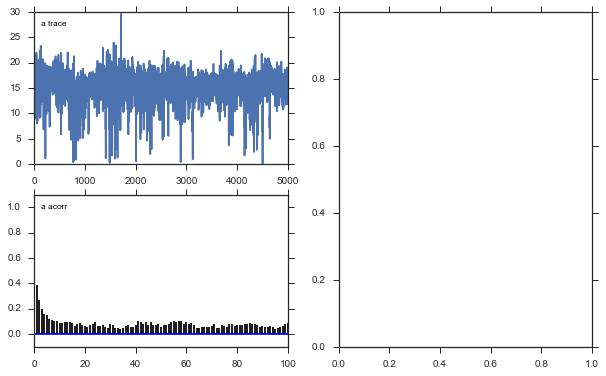

In [28]:
m=hddm.HDDM(cdata, depends_on={'v':['stim','speed'],'z':'cue'}, informative=False, bias=True, include=params)

m.sample(8000, burn=3000, dbname="speed_allcor_traces.db", db='pickle')
m.print_stats("stats.txt")
mstats=m.gen_stats()
mstats.to_csv('speed_allcor_stats.csv')
m.plot_posteriors(save=True)

## Get Model Stats

### Re-Format For Subject Grouping

In [39]:
mstats['param']=mstats.index
sx=stats_df(mstats)
sxdf=sx.copy() 
sxdfx = sxdf[sxdf['sub']!='GRP']
sxdfx[['sub', 'param', 'mean', 'm']] 
plist=[p.split('_')[0] for p in sxdfx.param]
sxdf_parsed=sxdfx.copy()
sxdf_parsed['param']=plist
sxdf_parsed.to_csv('sxdf_all_models.csv')

# PREPARE CORRELATION DF

In [ ]:
out=parse.parse_stats(rhodf, input_isdf=True)
cdf=out[1]
cdf.columns=['hF', 'nF', 'fF', 'hH', 'nH', 'fH', 'idx', 'param', 'speed']

fast=cdf.query('speed=="fast" & param==["v", "z", "a"] & idx!=[25,28]')
slow=cdf.query('speed=="slow" & param==["v", "z", "a"] & idx!=[25,28]')
fast.reset_index(drop=True, inplace=True)
slow.reset_index(drop=True, inplace=True)

cols=['a', 'z', 'vFFast', 'vHFast', 'vFSlow', 'vHSlow']
vals=[fast.query('param=="a" & idx!=[25, 28]')['fF'].values, fast.query('param=="z" & idx!=[25, 28]')['fF'].values, fast.query('param=="v"')['fF'].values, - fast.query('param=="v"')['fH'].values, slow.query('param=="v"')['fF'].values, -slow.query('param=="v"')['fH'].values]

vdf=pd.DataFrame(dict(zip(cols, vals)), index=fast.idx.unique())
vdf.to_csv("speed_model_rho_df.csv", index=False)

## Generate Mean Parameters DF Across All 3 Runs

In [ ]:
pd.to_numeric()

In [40]:
mstats_parsed=parse_stats(m)
condsdf=mstats_parsed[1].convert_objects(convert_numeric=True)

/Users/kyle/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/Users/kyle/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/Users/kyle/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


## Make zCue DF (Subj x ParamCondition)

In [41]:
cdfall=condsdf.copy()
adf=cdfall[cdfall.param=='a']
zdf=cdfall[cdfall.param=='z']
#cdfall[cdfall.param=='a']*cdfall[cdfall.param=='z'])
a=adf.groupby('sub').mean().reset_index().iloc[:,2]
zzdf=zdf.loc[:, ['sub','param','a80H_face', 'b50N_face', 'c80F_face']]
zzdf.columns=['sub','param','zH', 'zN', 'zF']
zzdf['a']=a.values

## Make vCueStim DF (Subj x ParamCondition)

In [42]:
vdf=cdfall[cdfall.param=='v']
vvdf=vdf.iloc[:, 2:]
vvdf.columns=['vHF','vNF','vFF','vHH','vNH','vFH']
vvdf.index=zzdf['sub'].values
zzdf.index=zzdf['sub'].values

## rho_df --> Concat zCue and vCueStim, Remove Idx Excl. from fMRI Analysis

In [43]:
rhodf=pd.concat([zzdf, vvdf], axis=1)
rhodf.drop('param', axis=1, inplace=True)
rhodf_img_subjects_only=rhodf.query('sub != [25,28]')
rho_df=rhodf_img_subjects_only.copy()

## HDDM MSM Model Parameters for Correlations with BOLD data

In [47]:
# Reverse Sign of House Drifts 
rho_df[['vHH','vNH','vFH']]=-rho_df[['vHH','vNH','vFH']]

In [48]:
# Face Cue to a (Face bound)
rho_df['zF2a']=rho_df['a']-(rho_df['zF']*rho_df['a'])
# Face Cue to b (House bound)
rho_df['zF2b']=rho_df['zF']*rho_df['a']

# House Cue to a (Face bound)
rho_df['zH2a']=rho_df['a']-(rho_df['zH']*rho_df['a'])
# House Cue to b (House bound)
rho_df['zH2b']=rho_df['zH']*rho_df['a']

# (Face Cue) Face Drifts (divided by distance to face bound)
rho_df['vFF_n_zF2a']=rho_df['vFF']/rho_df['zF2a']
# (Face Cue) Face Drifts (divided by boundary height)
rho_df['vFF_n_a']=rho_df['vFF']/rho_df['a']

# (Face Cue) House Drifts (divided by distance to house bound)
rho_df['vFH_n_zF2b']=rho_df['vFH']/rho_df['zF2b']
# (Face Cue) House Drifts (divided by boundary height)
rho_df['vFH_n_a']=rho_df['vFH']/rho_df['a']

# (House Cue) Face Drifts (divided by distance to face bound)
rho_df['vHF_n_zH2a']=rho_df['vHF']/rho_df['zH2a']
# (House Cue) Face Drifts (divided by boundary height)
rho_df['vHF_n_a']=rho_df['vHF']/rho_df['a']

# (House Cue) House Drifts (divided by distance to house bound)
rho_df['vHH_n_zH2b']=rho_df['vHH']/rho_df['zH2b']
# (House Cue) House Drifts (divided by boundary height)
rho_df['vHH_n_a']=rho_df['vHH']/rho_df['a']

## Save rho_df

In [51]:
rho_df.to_csv("/Users/kyle/Dropbox/PFH/iPFH/msm_allcor/msm_allcor_rho_df.csv")
#os.chdir("/Users/kyle/Dropbox/PFH/iPFH/msm_allcor")

## Get BOLD Vectors, Format, and Save PPA, FFA, and Diff DFs

In [ ]:
os.chdir("/home/kyle/Dropbox/PFH/iPFH/")
ppa=pd.read_csv('PPA_WinPeakBold.csv')
ffa=pd.read_csv('FFA_WinPeakBold.csv')

cols=['hc', 'nc', 'fc', 'hcF', 'ncF', 'fcF', 'hcH', 'ncH', 'fcH']
ffa.columns=cols
ppa.columns=cols

for df in [ffa, ppa]:
    df['fc-fcH']=df['fcH']-df['fc']
    df['fc-fcF']=df['fcF']-df['fc']
    df['hc-hcH']=df['hcH']-df['hc']
    df['hc-hcF']=df['hcF']-df['hc']

diff=ffa-ppa
for df in [ffa, ppa, diff]:
    df['idx']=hddm_rho_df.idx.values

ffa.to_csv("/home/kyle/Dropbox/PFH/iPFH/ffa_rho_df.csv")
ppa.to_csv("/home/kyle/Dropbox/PFH/iPFH/ppa_rho_df.csv")
diff.to_csv("/home/kyle/Dropbox/PFH/iPFH/diff_rho_df.csv")